### Applied Time Series Analysis - Lab 2
Peter Woo

April 9, 2021



# Introduction

## Outliers

### Definition and Examples

Outliers are observations that are located farther away from other values than normal. For example, in a dataset with the values 1, 2, 3, 4, 500, the outlier would be 500. 

Outliers can be found in many different datasets. For example, looking at this boxplot of age distribution of Olympic atheletes by sport and gender:

![](https://i2.wp.com/statsinthewild.com/wp-content/uploads/2012/07/screen-shot-2012-07-09-at-11-49-59-am.png) 

The points that lie outside the box and whiskers are considered outliers. 

Outliers can be caused by a few reasons that include but are not limited to: data entry errors, measurement erros, experimental errors, data processing errors, sampling errors, or just simple natural novelties in data. 

Outliers are significant since it can often mislead interpretation of statistics derived from the dataset. For instance, the most common measure of central tendency, the mean, can be greatly affected by outliers. A value that is much larger or smaller than the rest of the values will bring the mean up/down and may not represent the dataset accurately. 

### Peirce's Criterion

Peirce's Criterion is a method for outlier detection designed by Benjamin Peirce. It was first published in 1852. The model eliminates outliers from a dataset. It does so by rejecting observations based on a likelihood ratio type of argument. A way this model is applied is through removing outliers from a pair of dataset to perform regression between them. It is a repeatable process that does not depend on other processes as it does not depend on observation data. 

### Other Outlier Identification Methods

There are a number of other methods to identify outliers. In the graph above, the method used is the interquartile range. To use this model, you first divide the data into four quartiles and calculate the interquartile range by subtracting the first quartile from the third quartile. 

Then,
any value greater than 

$Q_3 + (IQR * 1.5)$

or any value less than 

$Q_1 - (IQR * 1.5)$

can be considered an outlier. 

## FLUXNET and the 2015 dataset 

The FLUXNET Network is a network of meteorological sensors around the wotld that measure atmospheric state variables. The dataset examined in this lab is taken from the site "US-GOO," or Goodwin Creek in Mississippi. The two specific variables that will be studied here will be net ecosystem exchange (NEE) and incoming shortwave radiation (SW<sub>in</sub>). SW<sub>in</sub> is the independent variable and NEE is the dependent variable.  



# Methods

## Peirce's Criterion: R-Implementation

The first step to using Peirce's criterion to eliminate outliers is defining a function that calculates Peirce's $x^2$. 

In [1]:
peirce_dev <- function(N, n, m) {
    # N :: total number of observations
    # n :: number of outliers to be removed
    # m :: number of model unknowns (e.g., regression parameters)
    #
    # Check number of observations:
    if (N > 1) {
       # Calculate Q (Nth root of Gould's equation B):
       Q = (n^(n/N) * (N-n)^((N-n)/N))/N
       #
       # Initialize R values:
       Rnew = 1.0
       Rold = 0.0  # <- Necessary to prompt while loop
       #
       while (abs(Rnew-Rold) > (N*2.0e-16)) {
           # Calculate Lamda (1/(N-n)th root of Gould's equation A'):
           ldiv = Rnew^n
           if (ldiv == 0) {
              ldiv = 1.0e-6
           }
           Lamda = ((Q^N)/(ldiv))^(1.0/(N-n))
           #
           # Calculate x-squared (Gould's equation C):
           x2 = 1.0 + (N-m-n)/n * (1.0-Lamda^2.0)
           #
           # If x2 goes negative, set equal to zero:
           if (x2 < 0) {
              x2 = 0
              Rold = Rnew
           } else {
              #
              # Use x-squared to update R (Gould's equation D):
              # NOTE: error function (erfc) is replaced with pnorm (Rbasic):
              # source: 
              # http://stat.ethz.ch/R-manual/R-patched/library/stats/html/Normal.html
              Rold = Rnew
              Rnew = exp((x2-1)/2.0)*(2*pnorm(sqrt(x2)/sqrt(2)*sqrt(2), lower=FALSE))
           }
       }
    } else {
       x2 = 0
    }
    x2
}

## Finding the Outliers

The next step is to scale the Peirce's $x^2$ to the dataset by multiplying it to the mean squared error. Then, I will keep increasing the number of outliers to detect until I reach a point where the actual number of outliers dectected is less than the inputted number of outliers to detect.

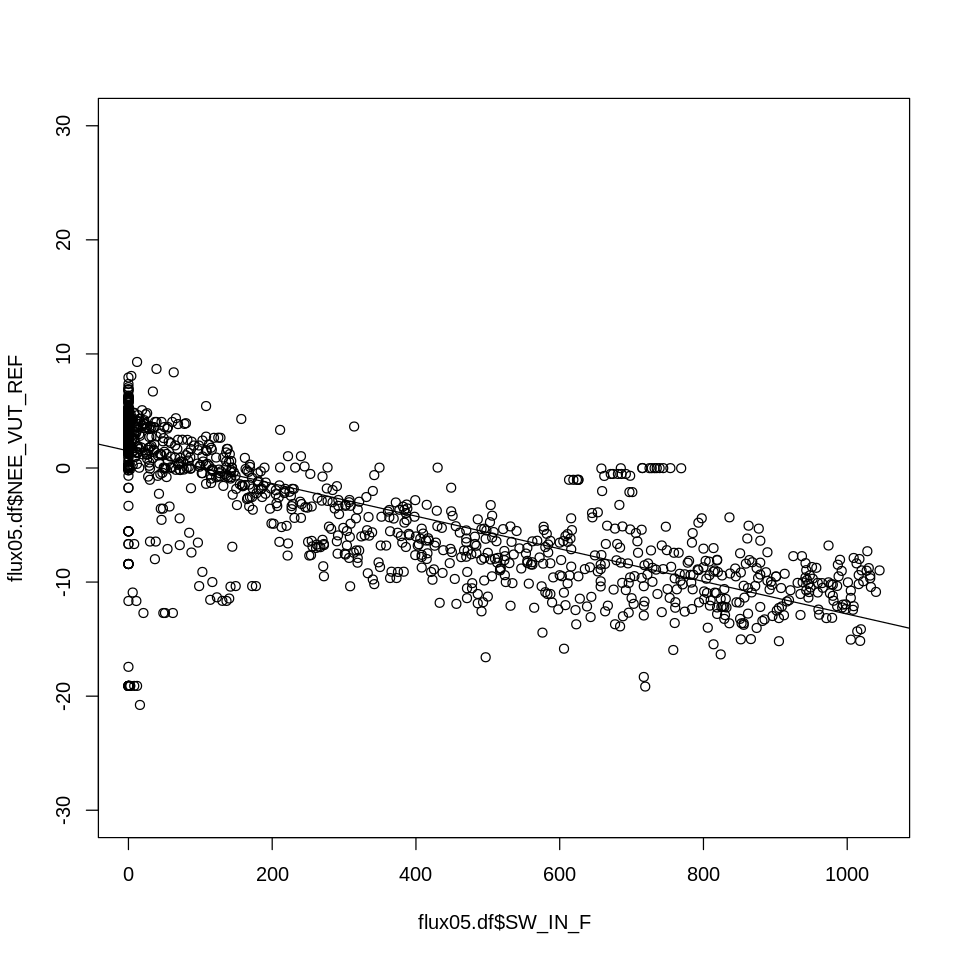

In [2]:
# Import the dataset

flux.url <- "https://ds-wm.github.io/course/atsa/data/FLX_US-Goo_FLUXNET2015_SUBSET_HH_2002-05_1-4.csv"
flux05.df <- read.csv(flux.url)

# Fit SWin against SEE
options(repr.plot.width = 8, repr.plot.height = 8)
lin.mod <- lm(flux05.df$NEE_VUT_REF ~ flux05.df$SW_IN_F)
plot(flux05.df$SW_IN_F, flux05.df$NEE_VUT_REF, ylim = c(-30, 30))
abline(lin.mod)

In [3]:
# Use the summary function for summary statistics

sm <- summary(lin.mod)
sm


Call:
lm(formula = flux05.df$NEE_VUT_REF ~ flux05.df$SW_IN_F)

Residuals:
     Min       1Q   Median       3Q      Max 
-22.0382  -1.2748   0.5612   2.0835   9.4803 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        1.495061   0.121450   12.31   <2e-16 ***
flux05.df$SW_IN_F -0.014301   0.000297  -48.15   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.716 on 1485 degrees of freedom
Multiple R-squared:  0.6096,	Adjusted R-squared:  0.6093 
F-statistic:  2318 on 1 and 1485 DF,  p-value: < 2.2e-16


In [4]:
# Define all the values necessary to calculate delta^2. 

x2 <- peirce_dev(N = length(flux05.df$NEE_VUT_REF),n = 1, m = 2)
se <- sm$residuals^2
mse <- mean(sm$residuals^2)

# Calculate delta^2

d2 <- x2 * mse

# Find how many outliers were found

n_index <- ifelse(se > d2,TRUE, FALSE)
found <- sum(n_index == TRUE)
found

[1] 16

In [9]:
# Keep increasing the value of n, until I find a value of n where the number of outliers found is less than n. 
# 48 seemed to be the first number n to satisfy the criteria. 

x2 <- peirce_dev(N = length(flux05.df$NEE_VUT_REF),n = 48, m = 2)
se <- sm$residuals^2
mse <- mean(sm$residuals^2)
d2 <- x2 * mse
n_index <- ifelse(se > d2,TRUE, FALSE)
found <- sum(n_index == TRUE)
found

[1] 47

In [10]:
# Now that I have determined the n value, I can determine which values are the outliers and remove them. 

outliers_NEE <- c(flux05.df$NEE_VUT_REF[n_index])
outliers_SWIN  <- c(flux05.df$SW_IN_F[n_index])

# Use negation to find values that are not ouliers 

cleared_NEE <- c(flux05.df$NEE_VUT_REF[!n_index])
cleared_SWIN <- c(flux05.df$SW_IN_F[!n_index])

# Results

Now, to visualize the data, I will use a scatterplot of SW<sub>in</sub> versus NEE with the outliers removed. The outliers will be plotted separately in red. 

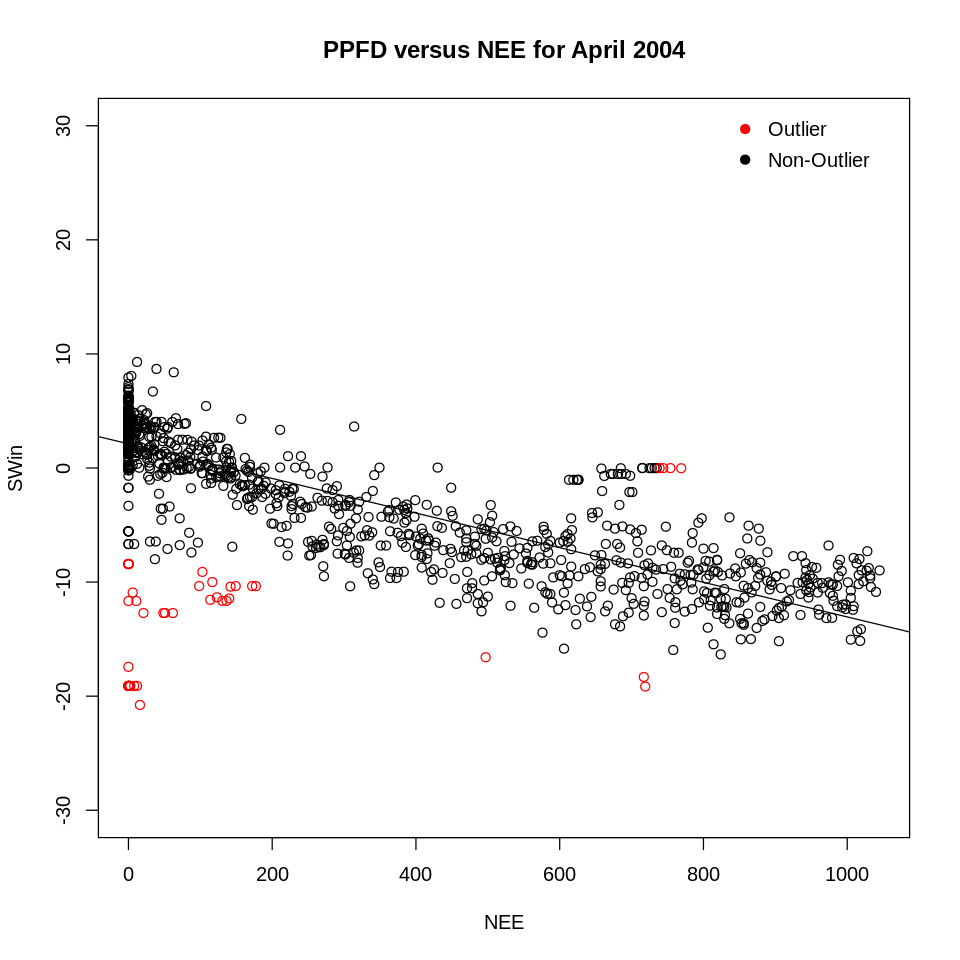

In [11]:
# Recreate the linear model with the datasets without outliers
lin.mod <- lm(cleared_NEE ~ cleared_SWIN)



# Create the plot 
plot(
  cleared_SWIN,
  cleared_NEE,
  main =  "PPFD versus NEE for April 2004",
  xlab = bquote("NEE"),
  ylab = bquote("SWin"),
  ylim = c(-30, 30)
)
points(outliers_SWIN, outliers_NEE, col = 'red')
abline(lin.mod)
legend(x = "topright", legend = c("Outlier", "Non-Outlier"), pch = c(19,19),  bty = "n", col = c('red', 'black'))

This figure demonstrates the outliers in red points and the actual points (non-outliers) in black. The fitted linear regression model is represented with the black line. There were a total of 47 outliers that were identified. 

# Discussions and Conclusions

The methods that I used were very straightforward and I did not run into any major problems. Reading through the GePiSaT documentation and going over the lecture video from class explained the process of using Peirce's Criterion to eliminate outliers. Calculating the nececssary metrics to use Peirce's Criterion were pretty simple with R's `summary` function. 

The results that I got were about what I expected. Looking at the graph, the red points that indicated outliers were far away from the cluster of values around the linear regression line.

The only thing I wish I could have done better would be automating the process for finding the correct n value for the `peirce_dev` function. I did it manually by repeatedly calling the function while increasing the n value. It would have been nice to create a loop so I can apply to other datasets as well.  

# References

Olympics boxplot. (2012, July 23). Retrieved April 07, 2021, from https://statsinthewild.com/2012/07/09/olympics-boxplot/

Peirce's criterion. (2020, December 22). Retrieved April 07, 2021, from https://en.wikipedia.org/wiki/Peirce%27s_criterion#cite_note-3

Santoyo, S. (2017, September 12). A Brief Overview of Outlier Detection Techniques. Retrieved April 07, 2021, from https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561#:~:text=Most%20common%20causes%20of%20outliers,made%20to%20test%20detection%20methods)

S. (2017, June 14). Pierce's criterion: Eliminating outliers from data sets. Retrieved April 07, 2021, from https://www.statisticshowto.com/pierces-criterion/#:~:text=How%20to%20use%20Peirce's%20Criterion&text=Look%20up%20the%20value%20of,calculate%20the%20maximum%20allowable%20deviation.

Taylor, C. (2018, April 27). What Is the Interquartile Range Rule? Retrieved April 07, 2021, from https://www.thoughtco.com/what-is-the-interquartile-range-rule-3126244
